# Домашнее задание "Модели ARIMA"

In [1]:
import warnings
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa as tsa
import statsmodels.tsa.api as smt 
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import boxcox
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor, RandomForestRegressor

warnings.simplefilter('ignore')

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    test_stationarity(y)
        
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()

# 1 Построение модели ARIMA для временного ряда закрытия промышленного индекса Доу Джонса

In [3]:
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
series = dowjones_closing['Close']
dowjones_closing[:6]

,Week,Close
0,1971-W27,890.19
1,1971-W28,901.80
2,1971-W29,888.51
3,1971-W30,887.78
4,1971-W31,858.43
5,1971-W32,850.61


Посмотрим график нашего ряда, а так же на графики автокорреляции и частичной автокорреляции

Results of Dickey-Fuller Test:
Test Statistic                  -1.314625
p-value                          0.622455
#Lags Used                       0.000000
Number of Observations Used    161.000000
Critical Value (1%)             -3.471633
Critical Value (5%)             -2.879665
Critical Value (10%)            -2.576434
dtype: float64


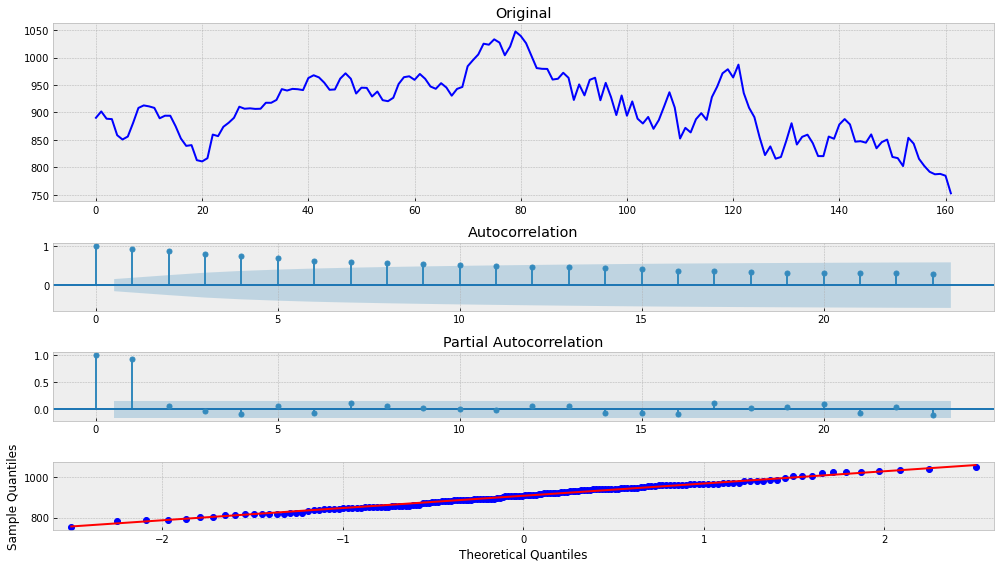

In [4]:
tsplot(series)

Данные не имеют сезонной составляющей, при этом наблюдается зависимость данных от предыдущих значений. По графику частичной автокорелации можно выбрать параметр p=1 для модели ARIMA, так как каждое текущее значение оказывает макссимальное влияние только на следующее значение. параметр q можно выбрать равным 7-10, так как график автокорреляции имеет более менее большие значения только на этом периоде.

Попробуем сделать ряд стационарным с помощью дифференцирования.

Results of Dickey-Fuller Test:
Test Statistic                -1.302521e+01
p-value                        2.407586e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


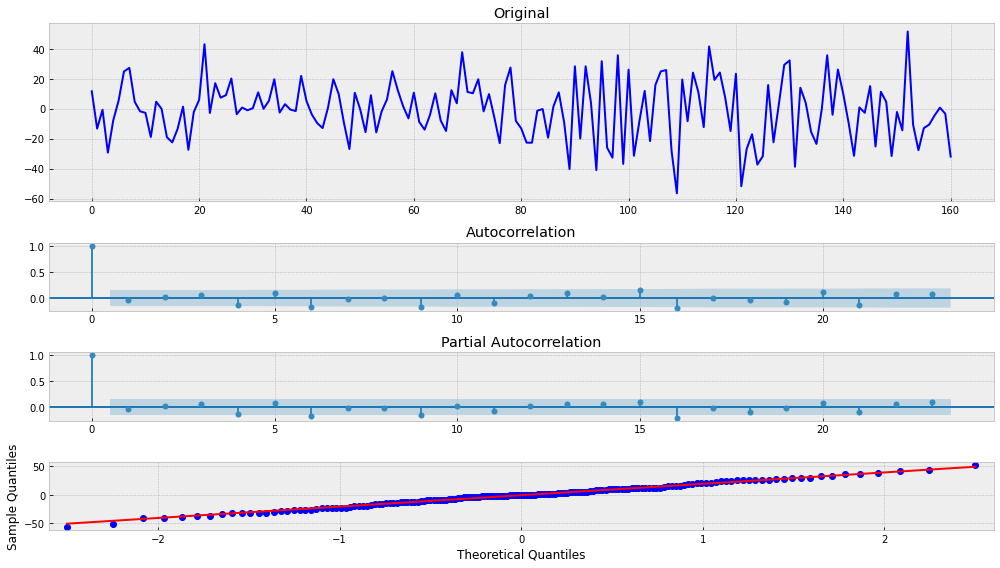

In [5]:
series_diff = np.diff(series, 1)
tsplot(series_diff)

Тест Дики-Фуллера пройден успешно и по графикам автокорреляций можно уверенно сказать, что временной ряд является стационарным. Исходя из этого можно выбрать параметр d=1 для модели ARIMA.

Попробуем подобрать автоматически наилучшие значения p, d и q на основе AIC.

In [6]:
def get_best_params(series, range_p=5, range_d=5, range_q=5, seasons_len=None, print_info=True,
                   return_model=False):
    """ Поиск лучших параметров на основе модели ARIMA
    
    Параметры
    ---------
    series : pandas series
      Временной ряд
    range_p : int, (int, int)
      Диапазон значений p. Если целое число, то диапазон от 0 до range_p.
      Если кортеж (start, end), то от start до end
    range_d : int, (int, int)
      Диапазон значений d. Если целое число, то диапазон от 0 до range_d.
      Если кортеж (start, end), то от start до end
    range_q : int, (int, int)
      Диапазон значений q. Если целое число, то диапазон от 0 до range_q.
      Если кортеж (start, end), то от start до end
    seasons_len : int
      Длина сезона. Если указана, то используется модель SARIMA. Если None, то используется ARIMA
    print_info : bool
      Если True, то выводит на экран информацию о лучших параметрах
    return_model : bool
      Если True, то возвращается лучшая обученная модель
      
    Результат
    ---------
    p, d, q, best_model : (int, int, int, model)
      Лучшие значения p, d, q и лучшая модель. Лучшая обученная модель возвращается 
      только при return_model=True
    """
    
    best_aic = np.inf
    
    best_p = None
    best_d = None
    best_q = None
    best_model = None
    
    seasons_len = int(seasons_len) if seasons_len else None
    
    try:
        
        if isinstance(range_p, int) or isinstance(range_p, float):
            range_p = tuple([int(range_p)])
        if isinstance(range_d, int) or isinstance(range_d, float):
            range_d = tuple([int(range_d)])
        if isinstance(range_q, int) or isinstance(range_q, float):
            range_q = tuple([int(range_q)]) 

        if not isinstance(range_p, tuple):
            range_p = tuple(range_p)
        if not isinstance(range_d, tuple):
            range_d = tuple(range_d)
        if not isinstance(range_q, tuple):
            range_q = tuple(range_q)
            
    except Exception as error:
        print(f'Произошла ошибка конвертации параметров в кортеж: {error}')
        return (best_p, best_d, best_q, best_model) if return_model else (best_p, best_d, best_q)
    
    cicle_count = len(range(*range_p)) * len(range(*range_d)) * len(range(*range_q))

    with tqdm(total=cicle_count) as pbar:
        for p in range(*range_p):
            for d in range(*range_d):
                for q in range(*range_q):
                    if seasons_len:
                        model_params = {'order': (p,d,q), 'seasonal_order': (p,d,q,seasons_len)}
                    else:
                        model_params = {'order': (p,d,q)}
                    model = tsa.arima.model.ARIMA(series, **model_params).fit()
                    if model.aic < best_aic:
                        best_aic = model.aic
                        best_p = p
                        best_d = d
                        best_q = q
                        best_model = model
                    pbar.update(1)             
                    
    print(f'Лучшие параметры: p={best_p}, d={best_d}, q={best_q}. AIC={best_aic}')
    
    return (best_p, best_d, best_q, best_model) if return_model else (best_p, best_d, best_q)

In [7]:
p, d, q, best_model = get_best_params(series, range_p=5, range_d=2, range_q=20, return_model=True)


Лучшие параметры: p=2, d=1, q=2. AIC=1417.2522778777711


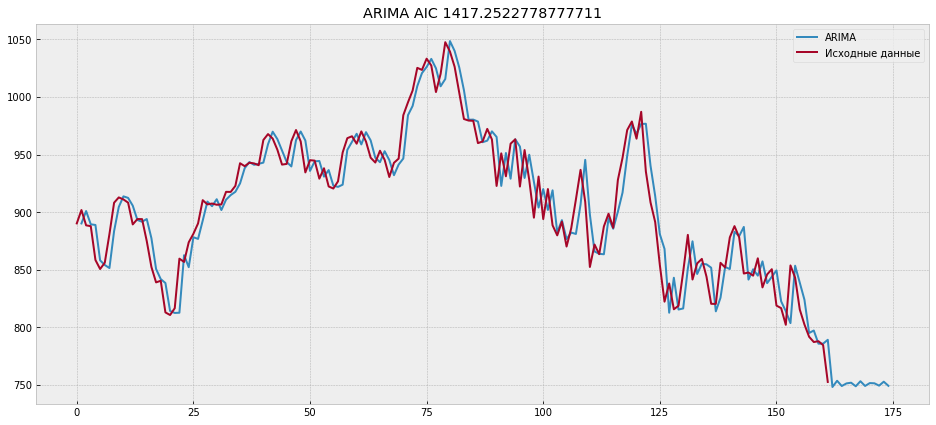

In [8]:
predict_weeks = 12
with plt.style.context('bmh'):
    plt.figure(figsize=(16,7))
    best_model.predict(1, len(series)+predict_weeks, typ='levels').plot(label='ARIMA')
    series.plot(label='Исходные данные')
    plt.title(f'ARIMA AIC {best_model.aic}')
    plt.legend()
    plt.show()

С атоматически подобранными параметрами модель ARIMA неплохо повторила исходные данные. Но предсказания сводятся к прямой линии. Стоит сказать, что модель ARIMA не предназначена для предсказания данных более чем на 1 шаг вперед.

Попробуем обучить модель с подобранными вручную параметрами.

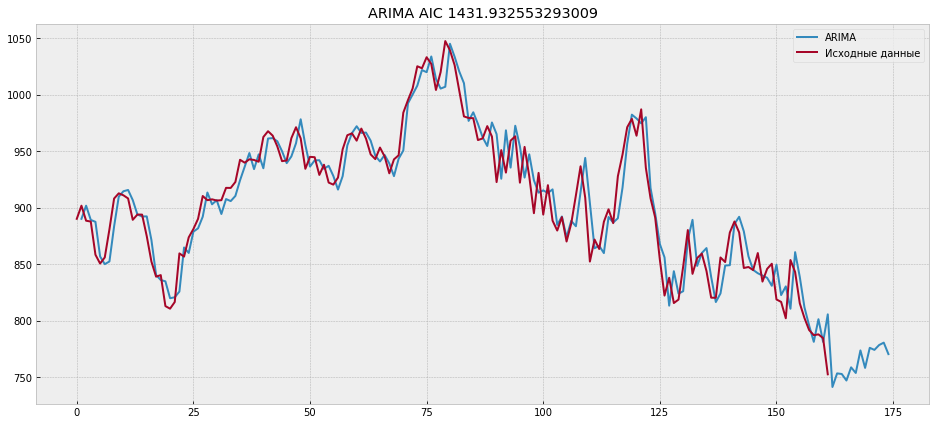

In [9]:
p, d, q = 1, 1, 15
model = tsa.arima.model.ARIMA(series, order=(p,d,q)).fit()

predict_weeks = 12
with plt.style.context('bmh'):
    plt.figure(figsize=(16,7))
    model.predict(1, len(series)+predict_weeks, typ='levels').plot(label='ARIMA')
    series.plot(label='Исходные данные')
    plt.title(f'ARIMA AIC {model.aic}')
    plt.legend()
    plt.show()

Графики моделей с ручными и автоматически подобранными параметрами не особо отличаются, кроме хвоста предсказаний. Так как мы пытаемся обучить модель с большей памятью старых данных по времени, то хвост предсказания имеет более сложную форму. Но все равно модель ARIMA не годится для долгосрочных предсказаний данного временного ряда.

# 2 Построение ансамблевой модели для временного ряда закрытия промышленного индекса Доу Джонса

Попробуем построить стекинговую модель для приближения значений временного ряда

In [10]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15, degree=None):
    
    data = pd.DataFrame(data.copy())
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Close.shift(i)
        
    data = data.dropna()
    data = data.reset_index(drop=True)
    #data = data.drop(["Week"], axis=1)
    data['Year'] = data['Week'].apply(lambda x: int(str(x).split('-')[0]))
    data['Week'] = data['Week'].apply(lambda x: int(str(x).split('W')[1]))
     
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Close"], axis=1)
    y_train = data.loc[:test_index]["Close"]
    X_test = data.loc[test_index:].drop(["Close"], axis=1)
    y_test = data.loc[test_index:]["Close"]
    
    if degree:
        polymome = PolynomialFeatures(degree=degree, interaction_only=True)
        X_train = polymome.fit_transform(X_train)
        X_test = polymome.transform(X_test)
    
    return X_train, X_test, y_train, y_test

Обязательно включаем первый лаг в данные для обучения, так как по графику частичной корреляции текущее значение влияет только на последующее.

In [11]:
X_train, X_test, y_train, y_test = prepareData(dowjones_closing, lag_start=1, lag_end=5,test_size=0.3)

Построим нашу стекинговую модель. В качестве моделей первого уровня выберем линейную регрессию и случайный лес с разными параметрами глубины дерева. А в качестве метамодели выберем линейную регрессию.

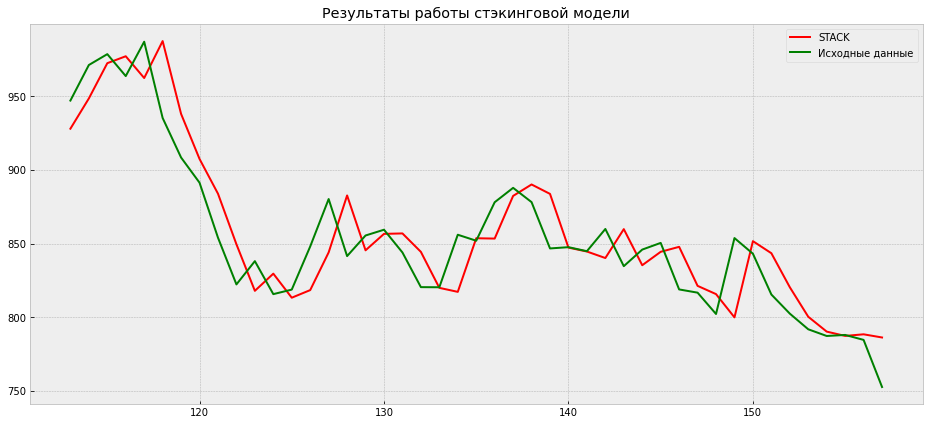

In [12]:
estimators = [
    ('lr', LinearRegression()),
    ('rf1', RandomForestRegressor(max_depth=10, random_state=42)),
    ('rf2', RandomForestRegressor(max_depth=100, random_state=42)),
    ('rf3', RandomForestRegressor(max_depth=250, random_state=42)),
    ('rf4', RandomForestRegressor(max_depth=500, random_state=42)),
    ('rf5', RandomForestRegressor(max_depth=1000, random_state=42)),
]
stack = StackingRegressor(estimators=estimators, 
                          final_estimator=LinearRegression())
stack.fit(X_train, y_train)
predict = stack.predict(X_test)
predict = pd.Series(predict, index=y_test.index)

with plt.style.context('bmh'):
    plt.figure(figsize=(16,7))
    plt.plot(predict, color='red', label='STACK')
    plt.plot(y_test, color='green', label='Исходные данные')
    plt.legend()
    plt.title('Результаты работы стэкинговой модели')
    plt.show()

Как видно модель неплохо смогла описать исходный временной ряд, но мы получили смещение по времени графика на одну единицу в будущее. Попробуем устранить это смещение свдигом предсказанных данных влево на 1 позицию.

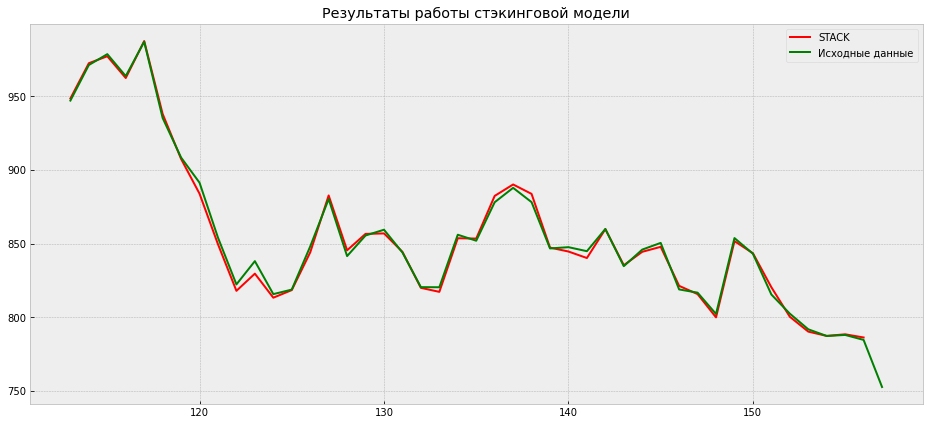

In [13]:
predict = stack.predict(X_test)
k = 1
predict = predict[k:]
predict = pd.Series(predict, index=y_test.index[:-k])

with plt.style.context('bmh'):
    plt.figure(figsize=(16,7))
    plt.plot(predict, color='red', label='STACK')
    plt.plot(y_test, color='green', label='Исходные данные')
    plt.legend()
    plt.title('Результаты работы стэкинговой модели')
    plt.show()

Теперь мы получили очень хорошее приближение исходных данных.

Теперь проверим как справится с аналогичной работой обычная линейная регрессия.

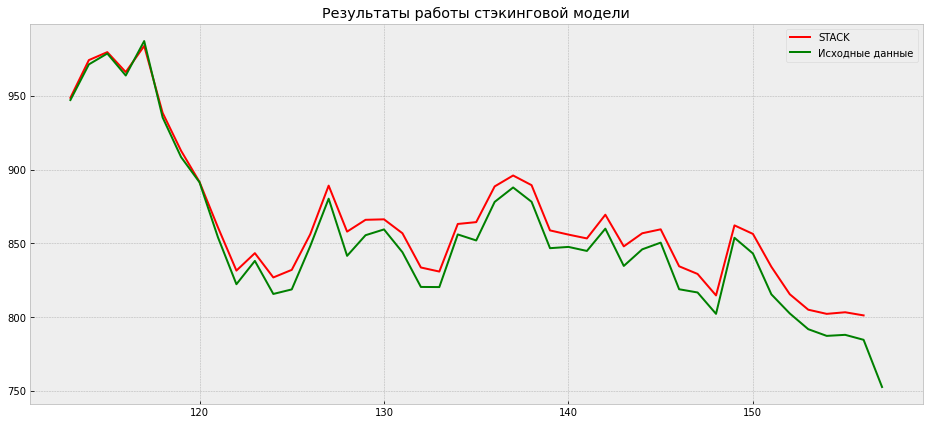

In [14]:
lr = LinearRegression()
lr.fit(X_train, y_train)
predict = lr.predict(X_test)

k = 1
predict = predict[k:]
predict = pd.Series(predict, index=y_test.index[:-k])

with plt.style.context('bmh'):
    plt.figure(figsize=(16,7))
    plt.plot(predict, color='red', label='STACK')
    plt.plot(y_test, color='green', label='Исходные данные')
    plt.legend()
    plt.title('Результаты работы стэкинговой модели')
    plt.show()

Обычная линейная регрессия сработала хуже, в первой четверти графика наблюдаем хорошее совпадение исходных и предсказанных данных, но потом предсказание получают смещение на увеличение значения.